In [1]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model, Sequential
import numpy as np
import os
import glob
from tqdm import tqdm	#Permite mostrar una barra de carga
import manipulacion_midi
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
tiempos_previos=5                   #Numero de tiempos previos utilizados para el entrenamiento y la prediccion
longitud_minima=15                  #Tamaño minimo (en tiempos) que deben tener las canciones del conjunto de entrenamiento
carpeta_canciones='../canciones_entrenamiento'       #Carpeta donde estan las canciones el entrenamiento
modelo_guardado='mejor_modelo_feedforward.hdf5' #Nombre del archivo donde se guardara el modelo entrenado

#Elimina los tiempos vacios antes de todas las canciones
def eliminar_zeros_iniciales(arr):
    i=0
    ceros=np.zeros_like(arr[0])
    tamano=np.size(arr,0)
    while np.array_equal(arr[i],ceros) and tamano!=1:
        arr=np.delete(arr,i, axis=0)
        tamano=tamano-1
    return arr

#Almacena en matrices las canciones MIDI de entrenamiento
def leer_canciones(ruta):
    print('Cargando archivos...')
    archivos = glob.glob('{}/*.mid*'.format(ruta))
    archivos = np.array(np.sort(archivos))
    archivos = archivos.tolist()
    global canciones
    global numero_cancion
    canciones = []
    numero_cancion=0
    for f in tqdm(archivos):
        print(f)
        try:
            cancion = np.array(manipulacion_midi.midiToNoteStateMatrix(f))			#Convierte los archivos .mid a matrices 
            cancion=eliminar_zeros_iniciales(cancion)
            tam = np.array(cancion).shape[0]
            print(tam)
            if tam > longitud_minima:
                if(numero_cancion==0):
                    canciones=cancion
                    numero_cancion=numero_cancion+1
                else:
                    canciones= np.concatenate([canciones, cancion], axis=0)
                    numero_cancion=numero_cancion+1
        except Exception as e:
            raise e
    return canciones

#Convierte el arreglo 2D de entradas en un arreglo 3D para entrenar el sistema
def dimensionar(w):
    for t, val in enumerate(w):
        u[0, t] = val
    return u

In [3]:
#Cargar canciones
canciones = leer_canciones(carpeta_canciones)

print("Se cargaron {} canciones".format(numero_cancion))

Cargando archivos...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

../canciones_entrenamiento\K19d Piano Sonata Duet.mid
1761


  3%|██▊                                                                                | 1/30 [00:00<00:18,  1.61it/s]

../canciones_entrenamiento\K279 Piano sonata n01 1mov.mid
2204


  7%|█████▌                                                                             | 2/30 [00:01<00:17,  1.61it/s]

../canciones_entrenamiento\K279 Piano sonata n01 3mov.mid
1708


 10%|████████▎                                                                          | 3/30 [00:01<00:16,  1.65it/s]

../canciones_entrenamiento\K281 Piano Sonata n03 1mov.mid
2516


 13%|███████████                                                                        | 4/30 [00:02<00:16,  1.54it/s]

../canciones_entrenamiento\K281 Piano Sonata n03 3mov.mid
2387


 17%|█████████████▊                                                                     | 5/30 [00:03<00:20,  1.21it/s]

../canciones_entrenamiento\K309 Piano Sonata n10 1mov.mid
4957


 20%|████████████████▌                                                                  | 6/30 [00:07<00:37,  1.56s/it]

../canciones_entrenamiento\K309 Piano Sonata n10 3mov.mid
2014


 23%|███████████████████▎                                                               | 7/30 [00:08<00:37,  1.61s/it]

../canciones_entrenamiento\K330 Piano Sonata n10 1mov.mid
2399


 27%|██████████████████████▏                                                            | 8/30 [00:10<00:34,  1.56s/it]

../canciones_entrenamiento\K330 Piano Sonata n10 3mov.mid
2731


 30%|████████████████████████▉                                                          | 9/30 [00:11<00:32,  1.53s/it]

../canciones_entrenamiento\K331 Piano sonata n11 3mov.mid
1785


 33%|███████████████████████████▎                                                      | 10/30 [00:12<00:25,  1.26s/it]

../canciones_entrenamiento\K333 Piano Sonata n13 1mov.mid
5281


 37%|██████████████████████████████                                                    | 11/30 [00:14<00:31,  1.67s/it]

../canciones_entrenamiento\K333 Piano Sonata n13 3mov.mid
3153


 40%|████████████████████████████████▊                                                 | 12/30 [00:16<00:30,  1.67s/it]

../canciones_entrenamiento\K358 Piano Sonata 4 Hands.mid
1777


 43%|███████████████████████████████████▌                                              | 13/30 [00:17<00:22,  1.33s/it]

../canciones_entrenamiento\K381 Piano Sonata 4 Hands.mid
1553


 47%|██████████████████████████████████████▎                                           | 14/30 [00:17<00:17,  1.08s/it]

../canciones_entrenamiento\K521 Piano Sonata 4 Hands.mid
3649


 50%|█████████████████████████████████████████                                         | 15/30 [00:18<00:16,  1.10s/it]

../canciones_entrenamiento\K545 Piano Sonata.mid
2369


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:19<00:13,  1.01it/s]

../canciones_entrenamiento\K570 Piano Sonata 2mov.mid
1265


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:19<00:10,  1.21it/s]

../canciones_entrenamiento\K570 Piano Sonata 3mov.mid
1939


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:20<00:08,  1.40it/s]

../canciones_entrenamiento\Piano Sonata n01 K279.mid
1617


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:21<00:08,  1.23it/s]

../canciones_entrenamiento\Piano Sonata n03 K281.mid
1745


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:22<00:08,  1.17it/s]

../canciones_entrenamiento\Piano Sonata n04 K282.mid
1153


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:23<00:07,  1.26it/s]

../canciones_entrenamiento\Piano Sonata n06 K284.mid
2033


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:24<00:07,  1.08it/s]

../canciones_entrenamiento\Piano Sonata n07 K309.mid
2481


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:25<00:07,  1.08s/it]

../canciones_entrenamiento\Piano Sonata n08 K311.mid
3281


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:27<00:07,  1.27s/it]

../canciones_entrenamiento\Piano Sonata n09 K310.mid
2129


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:28<00:06,  1.27s/it]

../canciones_entrenamiento\Piano Sonata n10 K330.mid
2401


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:30<00:05,  1.28s/it]

../canciones_entrenamiento\Piano Sonata n13 K333.mid
2645


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:31<00:03,  1.33s/it]

../canciones_entrenamiento\Piano Sonata n14 K457.mid
4897


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:34<00:03,  1.76s/it]

../canciones_entrenamiento\Piano Sonata n15 K593-494.mid
3829


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:36<00:01,  1.86s/it]

../canciones_entrenamiento\Piano Sonata n16 K545.mid
1185


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.51s/it]


Se cargaron 30 canciones


In [4]:
len(canciones)

74844

In [4]:
#Definir la red neuronal 

model = Sequential()
model.add(Dense(400, activation='relu', input_dim=(tiempos_previos*156)))
model.add(Dropout(0.1))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(400, activation='relu'))
model.add(Dense(156))
model.add(Activation('sigmoid'))


In [6]:
#Cargar modelo guardado

model.load_weights(modelo_guardado)

In [7]:
#Define como se guarda el modelo

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['binary_crossentropy'])
checkpoint = ModelCheckpoint(modelo_guardado, monitor='binary_crossentropy', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [8]:
#Dividir las canciones en dos arreglos, uno para los tiempos previos y otro para tiempo de salida  

sentences=[]
next_values=[]
for i in range(0, len(canciones) - tiempos_previos):
    sentences.append(canciones[i: i + tiempos_previos])
    next_values.append(canciones[i + tiempos_previos])

In [9]:
#Convertir conjuntos de tiempos previos en un arreglo tridimensional 

X = np.zeros((len(sentences), tiempos_previos*156), dtype=np.int32)
for i, sentence in enumerate(sentences):
    X[i] = sentence.ravel() 
y = np.asarray(next_values)

In [ ]:
#Entrenar modelo

model.fit(X, y, epochs=10000, batch_size=200, callbacks=callbacks_list)

Epoch 1/10000
74839/74839 [==============================] - 24s - loss: 0.0914 - binary_crossentropy: 0.0914    
Epoch 2/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0607 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0617 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0616 - binary_crossentropy: 0.06 - ETA: 22s - loss: 0.0619 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0631 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0631 - binary_crossentropy: 0.06 - ETA: 22s - loss: 0.0632 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0630 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0623 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0622 - binary_crossentropy: 0.06 - ETA: 21s - loss: 0.0621 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0622 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0622 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0621 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0623 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0627 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0626 - binary_crossentropy: 0.06 - ETA: 20s - loss: 0.0627 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0595 - binary_crossentropy: 0.0595    
Epoch 3/10000
74839/74839 [==============================] - 28s - loss: 0.0537 - binary_crossentropy: 0.0537    
Epoch 4/10000


36600/74839 [=============>................] - ETA: 17s - loss: 0.0542 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0532 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0518 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0523 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0518 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0514 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0507 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0509 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0510 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0511 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0509 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0507 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0504 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0504 - binary_crossentropy: 0.05 - ETA: 16s - loss: 0.0506 - binary_crossentropy: 0.05 - ETA: 15s - loss: 0.0503 - binary_crossentropy: 0.05 - ETA: 15s - loss: 0.0501 - binary_crossentropy: 0.05 - ETA: 15s - loss: 0.0499 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0495 - binary_crossentropy: 0.0495    
Epoch 5/10000
74839/74839 [==============================] - 24s - loss: 0.0456 - binary_crossentropy: 0.0456    
Epoch 6/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0376 - binary_crossentropy: 0.03 - ETA: 19s - loss: 0.0429 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0436 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0427 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0428 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0427 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0420 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0425 - binary_crossentropy: 0.04 - ETA: 20s - loss: 0.0434 - binary_crossentropy: 0.04 - ETA: 19s - loss: 0.0434 - binary_crossentropy: 0.04 - ETA: 19s - loss: 0.0437 - binary_crossentropy: 0.04 - ETA: 25s - loss: 0.0437 - binary_crossentropy: 0.04 - ETA: 29s - loss: 0.0434 - binary_crossentropy: 0.04 - ETA: 33s - loss: 0.0435 - binary_crossentropy: 0.04 - ETA: 36s - loss: 0.0438 - binary_crossentropy: 0.04 - ETA: 38s - loss: 0.0437 - binary_crossentropy: 0.04 - ETA: 41s - loss: 0.0434 - binary_crossentropy: 0.04 - ETA: 44s - loss: 0.0433 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0425 - binary_crossentropy: 0.0425    
Epoch 7/10000
74839/74839 [==============================] - 27s - loss: 0.0397 - binary_crossentropy: 0.0397    
Epoch 8/10000


31600/74839 [===========>..................] - ETA: 17s - loss: 0.0375 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0392 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0380 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0380 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0384 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0381 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0377 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0369 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0373 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0372 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0374 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0373 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0370 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0369 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0369 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0370 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0370 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0369 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0372 - binary_crossentropy: 0.0372    
Epoch 9/10000
74839/74839 [==============================] - 26s - loss: 0.0351 - binary_crossentropy: 0.0351    
Epoch 10/10000


31600/74839 [===========>..................] - ETA: 17s - loss: 0.0338 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0356 - binary_crossentropy: 0.03 - ETA: 19s - loss: 0.0359 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0341 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0341 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0338 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0336 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0335 - binary_crossentropy: 0.03 - ETA: 18s - loss: 0.0333 - binary_crossentropy: 0.03 - ETA: 23s - loss: 0.0329 - binary_crossentropy: 0.03 - ETA: 27s - loss: 0.0329 - binary_crossentropy: 0.03 - ETA: 30s - loss: 0.0325 - binary_crossentropy: 0.03 - ETA: 33s - loss: 0.0322 - binary_crossentropy: 0.03 - ETA: 35s - loss: 0.0324 - binary_crossentropy: 0.03 - ETA: 38s - loss: 0.0326 - binary_crossentropy: 0.03 - ETA: 41s - loss: 0.0326 - binary_crossentropy: 0.03 - ETA: 43s - loss: 0.0325 - binary_crossentropy: 0.03 - ETA: 45s - loss: 0.0325 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0333 - binary_crossentropy: 0.0333    
Epoch 11/10000
74839/74839 [==============================] - 27s - loss: 0.0317 - binary_crossentropy: 0.0317    
Epoch 12/10000


33000/74839 [============>.................] - ETA: 17s - loss: 0.0319 - binary_crossentropy: 0.03 - ETA: 16s - loss: 0.0292 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0293 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0291 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0288 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0287 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0291 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0288 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0285 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0289 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0286 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0286 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0286 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0284 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0283 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0283 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0284 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0285 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0303 - binary_crossentropy: 0.0303    
Epoch 13/10000
74839/74839 [==============================] - 27s - loss: 0.0291 - binary_crossentropy: 0.0291    
Epoch 14/10000


33000/74839 [============>.................] - ETA: 18s - loss: 0.0271 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0266 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0272 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0273 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0269 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0267 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0267 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0268 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0270 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0272 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0271 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0271 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0271 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0278 - binary_crossentropy: 0.0278    
Epoch 15/10000
74839/74839 [==============================] - 27s - loss: 0.0268 - binary_crossentropy: 0.0268    
Epoch 16/10000


30600/74839 [===========>..................] - ETA: 67s - loss: 0.0274 - binary_crossentropy: 0.02 - ETA: 66s - loss: 0.0271 - binary_crossentropy: 0.02 - ETA: 68s - loss: 0.0260 - binary_crossentropy: 0.02 - ETA: 71s - loss: 0.0253 - binary_crossentropy: 0.02 - ETA: 74s - loss: 0.0255 - binary_crossentropy: 0.02 - ETA: 75s - loss: 0.0254 - binary_crossentropy: 0.02 - ETA: 67s - loss: 0.0252 - binary_crossentropy: 0.02 - ETA: 61s - loss: 0.0250 - binary_crossentropy: 0.02 - ETA: 57s - loss: 0.0254 - binary_crossentropy: 0.02 - ETA: 53s - loss: 0.0250 - binary_crossentropy: 0.02 - ETA: 50s - loss: 0.0250 - binary_crossentropy: 0.02 - ETA: 47s - loss: 0.0250 - binary_crossentropy: 0.02 - ETA: 45s - loss: 0.0251 - binary_crossentropy: 0.02 - ETA: 43s - loss: 0.0249 - binary_crossentropy: 0.02 - ETA: 42s - loss: 0.0248 - binary_crossentropy: 0.02 - ETA: 40s - loss: 0.0247 - binary_crossentropy: 0.02 - ETA: 39s - loss: 0.0244 - binary_crossentropy: 0.02 - ETA: 38s - loss: 0.0245 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0258 - binary_crossentropy: 0.0258    
Epoch 17/10000
74839/74839 [==============================] - 27s - loss: 0.0250 - binary_crossentropy: 0.0250    
Epoch 18/10000


30800/74839 [===========>..................] - ETA: 18s - loss: 0.0221 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0222 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0226 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0226 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0226 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0224 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0221 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0218 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0217 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0216 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0217 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0218 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0220 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0221 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0222 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0224 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0224 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0225 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0241 - binary_crossentropy: 0.0241    
Epoch 19/10000
74839/74839 [==============================] - 26s - loss: 0.0233 - binary_crossentropy: 0.0233    
Epoch 20/10000


32600/74839 [============>.................] - ETA: 18s - loss: 0.0208 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0215 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0208 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0211 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0212 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0207 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0209 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0208 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0208 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0209 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0212 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0213 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0213 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0210 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0210 - binary_crossentropy: 0.02 - ETA: 18s - loss: 0.0210 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0211 - binary_crossentropy: 0.02 - ETA: 17s - loss: 0.0213 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0227 - binary_crossentropy: 0.0227    
Epoch 21/10000
74839/74839 [==============================] - 27s - loss: 0.0221 - binary_crossentropy: 0.0221    
Epoch 22/10000


30200/74839 [===========>..................] - ETA: 79s - loss: 0.0205 - binary_crossentropy: 0.02 - ETA: 76s - loss: 0.0203 - binary_crossentropy: 0.02 - ETA: 76s - loss: 0.0196 - binary_crossentropy: 0.01 - ETA: 81s - loss: 0.0196 - binary_crossentropy: 0.01 - ETA: 83s - loss: 0.0196 - binary_crossentropy: 0.01 - ETA: 83s - loss: 0.0202 - binary_crossentropy: 0.02 - ETA: 84s - loss: 0.0207 - binary_crossentropy: 0.02 - ETA: 84s - loss: 0.0208 - binary_crossentropy: 0.02 - ETA: 79s - loss: 0.0204 - binary_crossentropy: 0.02 - ETA: 73s - loss: 0.0203 - binary_crossentropy: 0.02 - ETA: 68s - loss: 0.0202 - binary_crossentropy: 0.02 - ETA: 64s - loss: 0.0201 - binary_crossentropy: 0.02 - ETA: 61s - loss: 0.0202 - binary_crossentropy: 0.02 - ETA: 58s - loss: 0.0204 - binary_crossentropy: 0.02 - ETA: 55s - loss: 0.0204 - binary_crossentropy: 0.02 - ETA: 53s - loss: 0.0205 - binary_crossentropy: 0.02 - ETA: 51s - loss: 0.0204 - binary_crossentropy: 0.02 - ETA: 50s - loss: 0.0205 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0214 - binary_crossentropy: 0.0214    
Epoch 23/10000
74839/74839 [==============================] - 29s - loss: 0.0209 - binary_crossentropy: 0.0209    
Epoch 24/10000


30200/74839 [===========>..................] - ETA: 31s - loss: 0.0170 - binary_crossentropy: 0.01 - ETA: 28s - loss: 0.0184 - binary_crossentropy: 0.01 - ETA: 53s - loss: 0.0180 - binary_crossentropy: 0.01 - ETA: 66s - loss: 0.0181 - binary_crossentropy: 0.01 - ETA: 76s - loss: 0.0191 - binary_crossentropy: 0.01 - ETA: 76s - loss: 0.0193 - binary_crossentropy: 0.01 - ETA: 78s - loss: 0.0188 - binary_crossentropy: 0.01 - ETA: 78s - loss: 0.0188 - binary_crossentropy: 0.01 - ETA: 77s - loss: 0.0185 - binary_crossentropy: 0.01 - ETA: 77s - loss: 0.0184 - binary_crossentropy: 0.01 - ETA: 76s - loss: 0.0184 - binary_crossentropy: 0.01 - ETA: 73s - loss: 0.0183 - binary_crossentropy: 0.01 - ETA: 69s - loss: 0.0185 - binary_crossentropy: 0.01 - ETA: 65s - loss: 0.0184 - binary_crossentropy: 0.01 - ETA: 62s - loss: 0.0187 - binary_crossentropy: 0.01 - ETA: 59s - loss: 0.0188 - binary_crossentropy: 0.01 - ETA: 56s - loss: 0.0188 - binary_crossentropy: 0.01 - ETA: 54s - loss: 0.0190 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0204 - binary_crossentropy: 0.0204    
Epoch 25/10000
74839/74839 [==============================] - 28s - loss: 0.0199 - binary_crossentropy: 0.0199    
Epoch 26/10000


30400/74839 [===========>..................] - ETA: 16s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0170 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0181 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0180 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0180 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0179 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0177 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0171 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0172 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0170 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0175 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0175 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0194 - binary_crossentropy: 0.0194    
Epoch 27/10000
74839/74839 [==============================] - 27s - loss: 0.0190 - binary_crossentropy: 0.0190    
Epoch 28/10000


31400/74839 [===========>..................] - ETA: 18s - loss: 0.0175 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0179 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0177 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0176 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0177 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0175 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0175 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0172 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0171 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0171 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0172 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 24s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 26s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 28s - loss: 0.0173 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0174 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0187 - binary_crossentropy: 0.0187    
Epoch 29/10000
74839/74839 [==============================] - 29s - loss: 0.0184 - binary_crossentropy: 0.0184    
Epoch 30/10000


31600/74839 [===========>..................] - ETA: 18s - loss: 0.0157 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0157 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0160 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0165 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0163 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0164 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0161 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0164 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0163 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0163 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0159 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0161 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0161 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0161 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0163 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0166 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0167 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0166 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0178 - binary_crossentropy: 0.0178    
Epoch 31/10000
74839/74839 [==============================] - 27s - loss: 0.0176 - binary_crossentropy: 0.0176    
Epoch 32/10000


31600/74839 [===========>..................] - ETA: 64s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 65s - loss: 0.0146 - binary_crossentropy: 0.01 - ETA: 70s - loss: 0.0144 - binary_crossentropy: 0.01 - ETA: 72s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 74s - loss: 0.0152 - binary_crossentropy: 0.01 - ETA: 74s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 77s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 77s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 78s - loss: 0.0146 - binary_crossentropy: 0.01 - ETA: 76s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 71s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 66s - loss: 0.0152 - binary_crossentropy: 0.01 - ETA: 63s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 59s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 57s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 54s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 52s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 50s - loss: 0.0156 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0173 - binary_crossentropy: 0.0173    
Epoch 33/10000
74839/74839 [==============================] - 27s - loss: 0.0170 - binary_crossentropy: 0.0170    
Epoch 34/10000


30800/74839 [===========>..................] - ETA: 18s - loss: 0.0156 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0137 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0139 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0141 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0146 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0150 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0159 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0157 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0159 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0158 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0157 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0156 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0155 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0167 - binary_crossentropy: 0.0167    
Epoch 35/10000
74839/74839 [==============================] - 30s - loss: 0.0164 - binary_crossentropy: 0.0164    
Epoch 36/10000


30400/74839 [===========>..................] - ETA: 19s - loss: 0.0186 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0172 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0174 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0170 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0168 - binary_crossentropy: 0.01 - ETA: 31s - loss: 0.0163 - binary_crossentropy: 0.01 - ETA: 36s - loss: 0.0161 - binary_crossentropy: 0.01 - ETA: 43s - loss: 0.0158 - binary_crossentropy: 0.01 - ETA: 48s - loss: 0.0156 - binary_crossentropy: 0.01 - ETA: 54s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 63s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 64s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 64s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 66s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 62s - loss: 0.0152 - binary_crossentropy: 0.01 - ETA: 60s - loss: 0.0152 - binary_crossentropy: 0.01 - ETA: 57s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 55s - loss: 0.0152 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0162 - binary_crossentropy: 0.0162    
Epoch 37/10000
74839/74839 [==============================] - 28s - loss: 0.0160 - binary_crossentropy: 0.0160    
Epoch 38/10000


31000/74839 [===========>..................] - ETA: 19s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0166 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0162 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0157 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0151 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0150 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0153 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0154 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0152 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0150 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0150 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0148 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0157 - binary_crossentropy: 0.0157    
Epoch 39/10000
74839/74839 [==============================] - 26s - loss: 0.0155 - binary_crossentropy: 0.0155    
Epoch 40/10000


30200/74839 [===========>..................] - ETA: 17s - loss: 0.0141 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0148 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0149 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0150 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0146 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0143 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0144 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0145 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0147 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0148 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0148 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0146 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0154 - binary_crossentropy: 0.0154    
Epoch 41/10000
74839/74839 [==============================] - 26s - loss: 0.0151 - binary_crossentropy: 0.0151    
Epoch 42/10000


32200/74839 [===========>..................] - ETA: 18s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0135 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0137 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0137 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0137 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0149 - binary_crossentropy: 0.0149    
Epoch 43/10000
74839/74839 [==============================] - 26s - loss: 0.0149 - binary_crossentropy: 0.0149    
Epoch 44/10000


33000/74839 [============>.................] - ETA: 17s - loss: 0.0128 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0137 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0137 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0138 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0136 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0135 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0135 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0134 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0147 - binary_crossentropy: 0.0147    
Epoch 45/10000
74839/74839 [==============================] - 22s - loss: 0.0145 - binary_crossentropy: 0.0145    
Epoch 46/10000


49000/74839 [==================>...........] - ETA: 16s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0139 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0130 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 25s - loss: 0.0130 - binary_crossentropy: 0.01 - ETA: 29s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 31s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 33s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 35s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 37s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 38s - loss: 0.0132 - binary_crossentropy: 0.01 - ETA: 39s - loss: 0.0132 - binary_crossentropy: 0.01 - ETA: 40s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 42s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 43s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 43s - loss: 0.0134 - binary_cr

74839/74839 [==============================] - 21s - loss: 0.0143 - binary_crossentropy: 0.0143    
Epoch 47/10000
74839/74839 [==============================] - 20s - loss: 0.0142 - binary_crossentropy: 0.0142    
Epoch 48/10000


50600/74839 [===================>..........] - ETA: 16s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0127 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0129 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0129 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0129 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0131 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0132 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0135 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0135 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0133 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0132 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0132 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0132 - binary_cr

74839/74839 [==============================] - 20s - loss: 0.0141 - binary_crossentropy: 0.0141    
Epoch 49/10000
74839/74839 [==============================] - 18s - loss: 0.0140 - binary_crossentropy: 0.0140    
Epoch 50/10000


48400/74839 [==================>...........] - ETA: 15s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0124 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0137 - binary_crossentropy: 0.0137    
Epoch 51/10000
74839/74839 [==============================] - 18s - loss: 0.0136 - binary_crossentropy: 0.0136    
Epoch 52/10000


50600/74839 [===================>..........] - ETA: 17s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0122 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0135 - binary_crossentropy: 0.0135    
Epoch 53/10000
74839/74839 [==============================] - 18s - loss: 0.0134 - binary_crossentropy: 0.0134    
Epoch 54/10000


49600/74839 [==================>...........] - ETA: 16s - loss: 0.0134 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0126 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0127 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0127 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0126 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0124 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0134 - binary_crossentropy: 0.0134    
Epoch 55/10000
74839/74839 [==============================] - 18s - loss: 0.0132 - binary_crossentropy: 0.0132    
Epoch 56/10000


52800/74839 [====================>.........] - ETA: 15s - loss: 0.0130 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0118 - binary_cr

74839/74839 [==============================] - 16s - loss: 0.0132 - binary_crossentropy: 0.0132    
Epoch 57/10000
74839/74839 [==============================] - 16s - loss: 0.0131 - binary_crossentropy: 0.0131    
Epoch 58/10000


50400/74839 [===================>..........] - ETA: 16s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0126 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0123 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0125 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0129 - binary_crossentropy: 0.0129    
Epoch 59/10000
74839/74839 [==============================] - 16s - loss: 0.0128 - binary_crossentropy: 0.0128    
Epoch 60/10000


50000/74839 [===================>..........] - ETA: 16s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0116 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0128 - binary_crossentropy: 0.0128    
Epoch 61/10000
74839/74839 [==============================] - 18s - loss: 0.0126 - binary_crossentropy: 0.0126    
Epoch 62/10000


52800/74839 [====================>.........] - ETA: 16s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0128 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0118 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0122 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0121 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0120 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0119 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0119 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0125 - binary_crossentropy: 0.0125    
Epoch 63/10000
74839/74839 [==============================] - 16s - loss: 0.0125 - binary_crossentropy: 0.0125    
Epoch 64/10000


52800/74839 [====================>.........] - ETA: 15s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0117 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0116 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_cr

74839/74839 [==============================] - 18s - loss: 0.0125 - binary_crossentropy: 0.0125    
Epoch 65/10000
74839/74839 [==============================] - 17s - loss: 0.0123 - binary_crossentropy: 0.0123    
Epoch 66/10000


46000/74839 [=================>............] - ETA: 16s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0109 - binary_cr

74839/74839 [==============================] - 20s - loss: 0.0122 - binary_crossentropy: 0.0122    
Epoch 67/10000
74839/74839 [==============================] - 16s - loss: 0.0122 - binary_crossentropy: 0.0122    
Epoch 68/10000


51600/74839 [===================>..........] - ETA: 17s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0112 - binary_cr

74839/74839 [==============================] - 20s - loss: 0.0121 - binary_crossentropy: 0.0121    
Epoch 69/10000
74839/74839 [==============================] - 23s - loss: 0.0121 - binary_crossentropy: 0.0121    
Epoch 70/10000


30600/74839 [===========>..................] - ETA: 20s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0107 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0120 - binary_crossentropy: 0.0120    
Epoch 71/10000
74839/74839 [==============================] - 20s - loss: 0.0119 - binary_crossentropy: 0.0119    
Epoch 72/10000


39600/74839 [==============>...............] - ETA: 16s - loss: 0.0125 - binary_crossentropy: 0.01 - ETA: 16s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 15s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 14s - loss: 0.0113 - binary_cr

69800/74839 [==========================>...] - ETA: 11s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0114 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 11s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 10s - loss: 0.0115 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0119 - binary_crossentropy: 0.0119    
Epoch 73/10000
74839/74839 [==============================] - 31s - loss: 0.0117 - binary_crossentropy: 0.0117    
Epoch 74/10000


30400/74839 [===========>..................] - ETA: 19s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 25s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 29s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 34s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 37s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 39s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 41s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 43s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 45s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 47s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 48s - loss: 0.0105 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0118 - binary_crossentropy: 0.0118    
Epoch 75/10000
74839/74839 [==============================] - 24s - loss: 0.0116 - binary_crossentropy: 0.0116    
Epoch 76/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0116 - binary_crossentropy: 0.0116    
Epoch 77/10000
74839/74839 [==============================] - 24s - loss: 0.0116 - binary_crossentropy: 0.0116    
Epoch 78/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0105 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0115 - binary_crossentropy: 0.0115    
Epoch 79/10000
74839/74839 [==============================] - 26s - loss: 0.0114 - binary_crossentropy: 0.0114    
Epoch 80/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0114 - binary_crossentropy: 0.0114    
Epoch 81/10000
74839/74839 [==============================] - 25s - loss: 0.0113 - binary_crossentropy: 0.0113    
Epoch 82/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0108 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0114 - binary_crossentropy: 0.0114    
Epoch 83/10000
74839/74839 [==============================] - 26s - loss: 0.0112 - binary_crossentropy: 0.0112    
Epoch 84/10000


30800/74839 [===========>..................] - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0102 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0112 - binary_crossentropy: 0.0112    
Epoch 85/10000
74839/74839 [==============================] - 25s - loss: 0.0111 - binary_crossentropy: 0.0111    
Epoch 86/10000


30800/74839 [===========>..................] - ETA: 17s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 25s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 28s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 31s - loss: 0.0102 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0112 - binary_crossentropy: 0.0112    
Epoch 87/10000
74839/74839 [==============================] - 29s - loss: 0.0111 - binary_crossentropy: 0.0111    
Epoch 88/10000


30200/74839 [===========>..................] - ETA: 68s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 81s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 101s - loss: 0.0099 - binary_crossentropy: 0.009 - ETA: 125s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 116s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 111s - loss: 0.0099 - binary_crossentropy: 0.009 - ETA: 105s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 94s - loss: 0.0102 - binary_crossentropy: 0.010 - ETA: 85s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 78s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 73s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 68s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 64s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 61s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 58s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 55s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 53s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 51s - loss: 0.0106 

74839/74839 [==============================] - 27s - loss: 0.0111 - binary_crossentropy: 0.0111    
Epoch 89/10000
74839/74839 [==============================] - 27s - loss: 0.0110 - binary_crossentropy: 0.0110    
Epoch 90/10000


30200/74839 [===========>..................] - ETA: 17s - loss: 0.0108 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0110 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0110 - binary_crossentropy: 0.0110    
Epoch 91/10000
74839/74839 [==============================] - 30s - loss: 0.0109 - binary_crossentropy: 0.0109    
Epoch 92/10000


31000/74839 [===========>..................] - ETA: 85s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 82s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 77s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 63s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 55s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 49s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 45s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 42s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 40s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 37s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 36s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 35s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 34s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 33s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 32s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 31s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 29s - loss: 0.0099 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0108 - binary_crossentropy: 0.0108    
Epoch 93/10000
74839/74839 [==============================] - 25s - loss: 0.0108 - binary_crossentropy: 0.0108    
Epoch 94/10000


31600/74839 [===========>..................] - ETA: 17s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0101 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0109 - binary_crossentropy: 0.0109    
Epoch 95/10000
74839/74839 [==============================] - 26s - loss: 0.0108 - binary_crossentropy: 0.0108    
Epoch 96/10000


34200/74839 [============>.................] - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0097 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0107 - binary_crossentropy: 0.0107    
Epoch 97/10000
74839/74839 [==============================] - 25s - loss: 0.0107 - binary_crossentropy: 0.0107    
Epoch 98/10000


31000/74839 [===========>..................] - ETA: 17s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0094 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0106 - binary_crossentropy: 0.0106    
Epoch 99/10000
74839/74839 [==============================] - 25s - loss: 0.0106 - binary_crossentropy: 0.0106    
Epoch 100/10000


31600/74839 [===========>..................] - ETA: 17s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0107 - binary_crossentropy: 0.0107    
Epoch 101/10000
74839/74839 [==============================] - 26s - loss: 0.0106 - binary_crossentropy: 0.0106    
Epoch 102/10000


31600/74839 [===========>..................] - ETA: 16s - loss: 0.0113 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0124 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0111 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0109 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0107 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0106 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 19s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0102 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0105 - binary_crossentropy: 0.0105    
Epoch 103/10000
74839/74839 [==============================] - 26s - loss: 0.0105 - binary_crossentropy: 0.0105    
Epoch 104/10000


30800/74839 [===========>..................] - ETA: 18s - loss: 0.0105 - binary_crossentropy: 0.01 - ETA: 17s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0105 - binary_crossentropy: 0.0105    
Epoch 105/10000
74839/74839 [==============================] - 27s - loss: 0.0105 - binary_crossentropy: 0.0105    
Epoch 106/10000


31000/74839 [===========>..................] - ETA: 16s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0093 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0104 - binary_crossentropy: 0.0104    
Epoch 107/10000
74839/74839 [==============================] - 28s - loss: 0.0104 - binary_crossentropy: 0.0104    
Epoch 108/10000


30200/74839 [===========>..................] - ETA: 23s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 23s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 64s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0094 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0103 - binary_crossentropy: 0.0103    
Epoch 109/10000
74839/74839 [==============================] - 23s - loss: 0.0103 - binary_crossentropy: 0.0103    
Epoch 110/10000


33000/74839 [============>.................] - ETA: 18s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0093 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0103 - binary_crossentropy: 0.0103    
Epoch 111/10000
74839/74839 [==============================] - 29s - loss: 0.0103 - binary_crossentropy: 0.0103    
Epoch 112/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0090 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0102 - binary_crossentropy: 0.0102    
Epoch 113/10000
74839/74839 [==============================] - 30s - loss: 0.0102 - binary_crossentropy: 0.0102    
Epoch 114/10000


30200/74839 [===========>..................] - ETA: 29s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 32s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 31s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 30s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 28s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 28s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 27s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 27s - loss: 0.0101 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0102 - binary_crossentropy: 0.0102    
Epoch 115/10000
74839/74839 [==============================] - 32s - loss: 0.0102 - binary_crossentropy: 0.0102    
Epoch 116/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0101 - binary_crossentropy: 0.0101    
Epoch 117/10000
74839/74839 [==============================] - 29s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 118/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 36s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 47s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 56s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 67s - loss: 0.0100 - binary_cr

74839/74839 [==============================] - 33s - loss: 0.0101 - binary_crossentropy: 0.0101    
Epoch 119/10000
74839/74839 [==============================] - 23s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 120/10000


31200/74839 [===========>..................] - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0092 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 121/10000
74839/74839 [==============================] - 28s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 122/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0089 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0099 - binary_crossentropy: 0.0099    
Epoch 123/10000
74839/74839 [==============================] - 25s - loss: 0.0099 - binary_crossentropy: 0.0099    
Epoch 124/10000


35600/74839 [=============>................] - ETA: 117s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 109s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 101s - loss: 0.0097 - binary_crossentropy: 0.009 - ETA: 95s - loss: 0.0096 - binary_crossentropy: 0.009 - ETA: 93s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 84s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0094 - bi

74839/74839 [==============================] - 25s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 125/10000
74839/74839 [==============================] - 31s - loss: 0.0099 - binary_crossentropy: 0.0099    
Epoch 126/10000


30200/74839 [===========>..................] - ETA: 92s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 70s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 54s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0090 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0100 - binary_crossentropy: 0.0100    
Epoch 127/10000
74839/74839 [==============================] - 28s - loss: 0.0098 - binary_crossentropy: 0.0098    
Epoch 128/10000


30200/74839 [===========>..................] - ETA: 81s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 102s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 103s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 102s - loss: 0.0086 - binary_crossentropy: 0.008 - ETA: 110s - loss: 0.0087 - binary_crossentropy: 0.008 - ETA: 107s - loss: 0.0088 - binary_crossentropy: 0.008 - ETA: 104s - loss: 0.0087 - binary_crossentropy: 0.008 - ETA: 101s - loss: 0.0087 - binary_crossentropy: 0.008 - ETA: 92s - loss: 0.0090 - binary_crossentropy: 0.009 - ETA: 85s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0

74839/74839 [==============================] - 31s - loss: 0.0097 - binary_crossentropy: 0.0097    
Epoch 129/10000
74839/74839 [==============================] - 25s - loss: 0.0098 - binary_crossentropy: 0.0098    
Epoch 130/10000


34800/74839 [============>.................] - ETA: 17s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0094 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0098 - binary_crossentropy: 0.0098    
Epoch 131/10000
74839/74839 [==============================] - 33s - loss: 0.0097 - binary_crossentropy: 0.0097    
Epoch 132/10000


30400/74839 [===========>..................] - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0092 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0098 - binary_crossentropy: 0.0098    
Epoch 133/10000
74839/74839 [==============================] - 30s - loss: 0.0097 - binary_crossentropy: 0.0097    
Epoch 134/10000


30600/74839 [===========>..................] - ETA: 58s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0087 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0097 - binary_crossentropy: 0.0097    
Epoch 135/10000
74839/74839 [==============================] - 29s - loss: 0.0097 - binary_crossentropy: 0.0097    
Epoch 136/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0115 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0093 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 137/10000
74839/74839 [==============================] - 31s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 138/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 139/10000
74839/74839 [==============================] - 32s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 140/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0095 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 141/10000
74839/74839 [==============================] - 33s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 142/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0088 - binary_cr

74839/74839 [==============================] - 35s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 143/10000
74839/74839 [==============================] - 32s - loss: 0.0095 - binary_crossentropy: 0.0095    
Epoch 144/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0089 - binary_cr

74839/74839 [==============================] - 33s - loss: 0.0096 - binary_crossentropy: 0.0096    
Epoch 145/10000
74839/74839 [==============================] - 33s - loss: 0.0095 - binary_crossentropy: 0.0095    
Epoch 146/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 23s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 24s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 24s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0093 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 147/10000
74839/74839 [==============================] - 31s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 148/10000


31200/74839 [===========>..................] - ETA: 16s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0087 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 149/10000
74839/74839 [==============================] - 29s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 150/10000


30200/74839 [===========>..................] - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0087 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 151/10000
74839/74839 [==============================] - 30s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 152/10000


30400/74839 [===========>..................] - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0089 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 153/10000
74839/74839 [==============================] - 28s - loss: 0.0094 - binary_crossentropy: 0.0094    
Epoch 154/10000


30400/74839 [===========>..................] - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0088 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 155/10000
74839/74839 [==============================] - 30s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 156/10000


30200/74839 [===========>..................] - ETA: 74s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0083 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 157/10000
74839/74839 [==============================] - 30s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 158/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 159/10000
74839/74839 [==============================] - 30s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 160/10000


30200/74839 [===========>..................] - ETA: 83s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0089 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0093 - binary_crossentropy: 0.0093    
Epoch 161/10000
74839/74839 [==============================] - 31s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 162/10000


30400/74839 [===========>..................] - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0093 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0089 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 163/10000
74839/74839 [==============================] - 31s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 164/10000


30600/74839 [===========>..................] - ETA: 69s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0084 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 165/10000
74839/74839 [==============================] - 29s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 166/10000


30400/74839 [===========>..................] - ETA: 87s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 92s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 44s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0085 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 167/10000
74839/74839 [==============================] - 30s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 168/10000


30200/74839 [===========>..................] - ETA: 83s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 92s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 92s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 97s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 95s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 95s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 94s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 88s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 81s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0082 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 169/10000
74839/74839 [==============================] - 31s - loss: 0.0092 - binary_crossentropy: 0.0092    
Epoch 170/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0104 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0103 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0101 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 20s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0097 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0093 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 171/10000
74839/74839 [==============================] - 32s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 172/10000


30400/74839 [===========>..................] - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 173/10000
74839/74839 [==============================] - 30s - loss: 0.0091 - binary_crossentropy: 0.0091    
Epoch 174/10000


30400/74839 [===========>..................] - ETA: 83s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 81s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 44s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0086 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 175/10000
74839/74839 [==============================] - 29s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 176/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0098 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0095 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 177/10000
74839/74839 [==============================] - 32s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 178/10000


30600/74839 [===========>..................] - ETA: 62s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 69s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0082 - binary_cr

74839/74839 [==============================] - 33s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 179/10000
74839/74839 [==============================] - 34s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 180/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0083 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 181/10000
74839/74839 [==============================] - 30s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 182/10000


31400/74839 [===========>..................] - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 44s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 69s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 75s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 76s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0079 - binary_cr

74839/74839 [==============================] - 32s - loss: 0.0090 - binary_crossentropy: 0.0090    
Epoch 183/10000
74839/74839 [==============================] - 33s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 184/10000


30200/74839 [===========>..................] - ETA: 83s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 83s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 85s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 89s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 94s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 86s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0084 - binary_cr

74839/74839 [==============================] - 34s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 185/10000
74839/74839 [==============================] - 35s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 186/10000


30200/74839 [===========>..................] - ETA: 22s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 33s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 187/10000
74839/74839 [==============================] - 30s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 188/10000


30600/74839 [===========>..................] - ETA: 16s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 189/10000
74839/74839 [==============================] - 25s - loss: 0.0089 - binary_crossentropy: 0.0089    
Epoch 190/10000


36400/74839 [=============>................] - ETA: 16s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0080 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 191/10000
74839/74839 [==============================] - 24s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 192/10000


74839/74839 [==============================] - 23s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 193/10000


33800/74839 [============>.................] - ETA: 17s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0083 - binary_cr

67200/74839 [=========================>....] - ETA: 14s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 14s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 14s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0085 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 194/10000
74839/74839 [==============================] - 24s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 195/10000


33400/74839 [============>.................] - ETA: 56s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0080 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 196/10000
74839/74839 [==============================] - 24s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 197/10000


34800/74839 [============>.................] - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0087 - binary_crossentropy: 0.0087    
Epoch 198/10000
74839/74839 [==============================] - 24s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 199/10000


36200/74839 [=============>................] - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0087 - binary_crossentropy: 0.0087    
Epoch 200/10000
74839/74839 [==============================] - 25s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 201/10000


35400/74839 [=============>................] - ETA: 18s - loss: 0.0061 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0083 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0088 - binary_crossentropy: 0.0088    
Epoch 202/10000
74839/74839 [==============================] - 26s - loss: 0.0087 - binary_crossentropy: 0.0087    
Epoch 203/10000


30600/74839 [===========>..................] - ETA: 22s - loss: 0.0112 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0102 - binary_crossentropy: 0.01 - ETA: 21s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0100 - binary_crossentropy: 0.01 - ETA: 22s - loss: 0.0096 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0087 - binary_crossentropy: 0.0087    
Epoch 204/10000
74839/74839 [==============================] - 26s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 205/10000


34600/74839 [============>.................] - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 206/10000
74839/74839 [==============================] - 28s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 207/10000


30600/74839 [===========>..................] - ETA: 19s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0087 - binary_crossentropy: 0.0087    
Epoch 208/10000
74839/74839 [==============================] - 24s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 209/10000


31400/74839 [===========>..................] - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 210/10000
74839/74839 [==============================] - 24s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 211/10000


34000/74839 [============>.................] - ETA: 18s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 212/10000
74839/74839 [==============================] - 23s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 213/10000


38200/74839 [==============>...............] - ETA: 16s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0081 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 214/10000
74839/74839 [==============================] - 25s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 215/10000


32800/74839 [============>.................] - ETA: 73s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 69s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0079 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 216/10000
74839/74839 [==============================] - 24s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 217/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0050 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 218/10000
74839/74839 [==============================] - 25s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 219/10000


30200/74839 [===========>..................] - ETA: 17s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0089 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 220/10000
74839/74839 [==============================] - 28s - loss: 0.0086 - binary_crossentropy: 0.0086    
Epoch 221/10000


30200/74839 [===========>..................] - ETA: 97s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 97s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 93s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 97s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 98s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 98s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 87s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 222/10000
74839/74839 [==============================] - 25s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 223/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 224/10000
74839/74839 [==============================] - 25s - loss: 0.0085 - binary_crossentropy: 0.0085    
Epoch 225/10000


30400/74839 [===========>..................] - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 226/10000
74839/74839 [==============================] - 23s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 227/10000


38200/74839 [==============>...............] - ETA: 17s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 228/10000
74839/74839 [==============================] - 21s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 229/10000


37200/74839 [=============>................] - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_cr

72200/74839 [===========================>..] - ETA: 9s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 9s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 9s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 9s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 9s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 8s - loss: 0.0082 - binary_cro

74839/74839 [==============================] - 20s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 230/10000
74839/74839 [==============================] - 23s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 231/10000


30600/74839 [===========>..................] - ETA: 18s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0084 - binary_crossentropy: 0.0084    
Epoch 232/10000
74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 241/10000


74839/74839 [==============================] - 29s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 242/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 77s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 76s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 69s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 243/10000
74839/74839 [==============================] - 29s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 244/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 245/10000
74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 246/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 247/10000
74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 248/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 249/10000
74839/74839 [==============================] - 27s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 250/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 251/10000
74839/74839 [==============================] - 28s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 252/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 253/10000
74839/74839 [==============================] - 26s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 254/10000


30200/74839 [===========>..................] - ETA: 83s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 92s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 96s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 100s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 98s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 98s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 100s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 96s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 88s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 81s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 75s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 64s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0076 - bin

74839/74839 [==============================] - 29s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 255/10000
74839/74839 [==============================] - 29s - loss: 0.0083 - binary_crossentropy: 0.0083    
Epoch 256/10000


30200/74839 [===========>..................] - ETA: 112s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 79s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 61s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0078 - binary

74839/74839 [==============================] - 28s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 257/10000
74839/74839 [==============================] - 28s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 258/10000


30200/74839 [===========>..................] - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0075 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 259/10000
74839/74839 [==============================] - 28s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 260/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 29s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 261/10000
74839/74839 [==============================] - 28s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 262/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 263/10000
74839/74839 [==============================] - 31s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 264/10000


30200/74839 [===========>..................] - ETA: 20s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0081 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 265/10000
74839/74839 [==============================] - 31s - loss: 0.0082 - binary_crossentropy: 0.0082    
Epoch 266/10000


30400/74839 [===========>..................] - ETA: 20s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_cr

74839/74839 [==============================] - 28s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 267/10000
74839/74839 [==============================] - 30s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 268/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 30s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 269/10000
74839/74839 [==============================] - 31s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 270/10000


30200/74839 [===========>..................] - ETA: 22s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 31s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 271/10000
74839/74839 [==============================] - 28s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 272/10000


30800/74839 [===========>..................] - ETA: 19s - loss: 0.0099 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0086 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 273/10000
74839/74839 [==============================] - 23s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 274/10000


35200/74839 [=============>................] - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 275/10000
74839/74839 [==============================] - 22s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 276/10000


74839/74839 [==============================] - 21s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 277/10000


38000/74839 [==============>...............] - ETA: 17s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_cr

73800/74839 [============================>.] - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 8s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_cro

74839/74839 [==============================] - 20s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 278/10000
74839/74839 [==============================] - 21s - loss: 0.0081 - binary_crossentropy: 0.0081    
Epoch 279/10000


35600/74839 [=============>................] - ETA: 16s - loss: 0.0058 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 15s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 15s - loss: 0.0073 - binary_cr

67200/74839 [=========================>....] - ETA: 12s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 280/10000
74839/74839 [==============================] - 20s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 281/10000


38400/74839 [==============>...............] - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_cr

74600/74839 [============================>.] - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 9s - loss: 0.0077 - binary_crossentropy: 0.0077 - ETA: 9s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 20s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 282/10000
74839/74839 [==============================] - 22s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 283/10000


37000/74839 [=============>................] - ETA: 17s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0077 - binary_cr

72400/74839 [============================>.] - ETA: 11s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 10s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.0078 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 9s - loss: 0.0078 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 284/10000
74839/74839 [==============================] - 24s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 285/10000


32000/74839 [===========>..................] - ETA: 17s - loss: 0.0052 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 286/10000
74839/74839 [==============================] - 23s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 287/10000


30400/74839 [===========>..................] - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 288/10000
74839/74839 [==============================] - 24s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 289/10000


30600/74839 [===========>..................] - ETA: 80s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 76s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0075 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 290/10000
74839/74839 [==============================] - 26s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 291/10000


30200/74839 [===========>..................] - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 292/10000
74839/74839 [==============================] - 25s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 293/10000


30400/74839 [===========>..................] - ETA: 18s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 294/10000
74839/74839 [==============================] - 24s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 295/10000


30200/74839 [===========>..................] - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 296/10000
74839/74839 [==============================] - 25s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 297/10000


31200/74839 [===========>..................] - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0080 - binary_crossentropy: 0.0080    
Epoch 298/10000
74839/74839 [==============================] - 24s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 299/10000


30400/74839 [===========>..................] - ETA: 17s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 26s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 300/10000
74839/74839 [==============================] - 25s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 301/10000


30400/74839 [===========>..................] - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 302/10000
74839/74839 [==============================] - 25s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 303/10000


30800/74839 [===========>..................] - ETA: 19s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 27s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 304/10000
74839/74839 [==============================] - 27s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 305/10000


32800/74839 [============>.................] - ETA: 17s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 306/10000
74839/74839 [==============================] - 24s - loss: 0.0079 - binary_crossentropy: 0.0079    
Epoch 307/10000


33600/74839 [============>.................] - ETA: 18s - loss: 0.0058 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0061 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0060 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0075 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 308/10000
74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 309/10000


36200/74839 [=============>................] - ETA: 17s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 310/10000
74839/74839 [==============================] - 22s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 311/10000


33800/74839 [============>.................] - ETA: 18s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 57s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 60s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 312/10000
74839/74839 [==============================] - 23s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 313/10000


34800/74839 [============>.................] - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 314/10000
74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 315/10000


34000/74839 [============>.................] - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 316/10000
74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 317/10000


33800/74839 [============>.................] - ETA: 76s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0068 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 318/10000
74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 319/10000


34400/74839 [============>.................] - ETA: 19s - loss: 0.0094 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 320/10000
74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 321/10000


36200/74839 [=============>................] - ETA: 17s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 322/10000
74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 323/10000


36000/74839 [=============>................] - ETA: 16s - loss: 0.0051 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 324/10000
74839/74839 [==============================] - 22s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 325/10000


37800/74839 [==============>...............] - ETA: 66s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 74s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 76s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 73s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 61s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 326/10000
74839/74839 [==============================] - 23s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 327/10000


35800/74839 [=============>................] - ETA: 16s - loss: 0.0058 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 328/10000
74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 329/10000


39000/74839 [==============>...............] - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 330/10000
74839/74839 [==============================] - 25s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 331/10000


34400/74839 [============>.................] - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 332/10000
74839/74839 [==============================] - 24s - loss: 0.0078 - binary_crossentropy: 0.0078    
Epoch 333/10000


35000/74839 [=============>................] - ETA: 19s - loss: 0.0090 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 334/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 335/10000


37000/74839 [=============>................] - ETA: 16s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 336/10000
74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 337/10000


34400/74839 [============>.................] - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0075 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 338/10000
74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 339/10000


34000/74839 [============>.................] - ETA: 17s - loss: 0.0056 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 340/10000
74839/74839 [==============================] - 22s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 341/10000


34000/74839 [============>.................] - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 342/10000
74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 343/10000


34800/74839 [============>.................] - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0091 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0088 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0083 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 344/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 345/10000


34800/74839 [============>.................] - ETA: 16s - loss: 0.0055 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 346/10000
74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 347/10000


34600/74839 [============>.................] - ETA: 17s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0061 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0061 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 22s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 348/10000
74839/74839 [==============================] - 25s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 349/10000


33200/74839 [============>.................] - ETA: 17s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0082 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 350/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 351/10000


35400/74839 [=============>................] - ETA: 16s - loss: 0.0084 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0079 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 352/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 353/10000


34800/74839 [============>.................] - ETA: 64s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0077 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 354/10000
74839/74839 [==============================] - 23s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 355/10000


34200/74839 [============>.................] - ETA: 78s - loss: 0.0060 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0053 - binary_crossentropy: 0.00 - ETA: 80s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 78s - loss: 0.0060 - binary_crossentropy: 0.00 - ETA: 75s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0076 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 356/10000
74839/74839 [==============================] - 22s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 357/10000


34400/74839 [============>.................] - ETA: 18s - loss: 0.0081 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 41s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 358/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 359/10000


32800/74839 [============>.................] - ETA: 17s - loss: 0.0085 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 360/10000
74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 361/10000


35400/74839 [=============>................] - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 362/10000
74839/74839 [==============================] - 22s - loss: 0.0077 - binary_crossentropy: 0.0077    
Epoch 363/10000


35200/74839 [=============>................] - ETA: 17s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0059 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0060 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0061 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 364/10000
74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 365/10000


32200/74839 [===========>..................] - ETA: 19s - loss: 0.0080 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 366/10000
74839/74839 [==============================] - 23s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 367/10000


32800/74839 [============>.................] - ETA: 18s - loss: 0.0092 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0087 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0078 - binary_crossentropy: 0.00 - ETA: 22s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 21s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 368/10000
74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 369/10000


31400/74839 [===========>..................] - ETA: 73s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 36s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 33s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 26s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 25s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 23s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 370/10000
74839/74839 [==============================] - 25s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 371/10000


32600/74839 [============>.................] - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 24s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 45s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0071 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 372/10000
74839/74839 [==============================] - 25s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 373/10000


32600/74839 [============>.................] - ETA: 17s - loss: 0.0058 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 374/10000
74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 375/10000


35600/74839 [=============>................] - ETA: 17s - loss: 0.0043 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0053 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0058 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 376/10000
74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 377/10000


33800/74839 [============>.................] - ETA: 18s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0077 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_cr

74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 378/10000
74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 379/10000


32400/74839 [===========>..................] - ETA: 19s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 20s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0070 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 380/10000
74839/74839 [==============================] - 24s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 381/10000


34600/74839 [============>.................] - ETA: 17s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 16s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 18s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0066 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 382/10000
74839/74839 [==============================] - 23s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 383/10000


32400/74839 [===========>..................] - ETA: 67s - loss: 0.0057 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 72s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 71s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0062 - binary_crossentropy: 0.00 - ETA: 70s - loss: 0.0063 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 62s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 59s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 56s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0068 - binary_cr

74839/74839 [==============================] - 25s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 384/10000
74839/74839 [==============================] - 23s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 385/10000


35600/74839 [=============>................] - ETA: 80s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 79s - loss: 0.0076 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 43s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 40s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 34s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 32s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 31s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 29s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 28s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 27s - loss: 0.0072 - binary_cr

74839/74839 [==============================] - 21s - loss: 0.0075 - binary_crossentropy: 0.0075    
Epoch 386/10000
74839/74839 [==============================] - 22s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 387/10000


34800/74839 [============>.................] - ETA: 57s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 65s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 68s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 67s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0064 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 66s - loss: 0.0066 - binary_crossentropy: 0.00 - ETA: 63s - loss: 0.0065 - binary_crossentropy: 0.00 - ETA: 58s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 55s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 48s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 46s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0067 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 38s - loss: 0.0069 - binary_crossentropy: 0.00 - ETA: 37s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0069 - binary_cr

70800/74839 [===========================>..] - ETA: 13s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 13s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 12s - loss: 0.0073 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 11s - loss: 0.0074 - binary_cr

74839/74839 [==============================] - 23s - loss: 0.0076 - binary_crossentropy: 0.0076    
Epoch 388/10000
74839/74839 [==============================] - 22s - loss: 0.0074 - binary_crossentropy: 0.0074    
Epoch 389/10000


35400/74839 [=============>................] - ETA: 15s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 17s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 19s - loss: 0.0074 - binary_crossentropy: 0.00 - ETA: 30s - loss: 0.0075 - binary_crossentropy: 0.00 - ETA: 35s - loss: 0.0072 - binary_crossentropy: 0.00 - ETA: 39s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 42s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 44s - loss: 0.0068 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 51s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 52s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 54s - loss: 0.0070 - binary_crossentropy: 0.00 - ETA: 53s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 50s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 49s - loss: 0.0071 - binary_crossentropy: 0.00 - ETA: 47s - loss: 0.0071 - binary_cr

74200/74839 [============================>.] - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 1s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 0s - loss: 0.0073 - binary_cro

KeyboardInterrupt: 

In [14]:
#Evaluar modelo
#Retorna el valor loss (definir mse) y metrics

model.evaluate(X, y, batch_size=200, verbose=1)

74800/74839 [============================>.] - ETA: 16 - ETA: 94s - ETA: 70 - ETA: 59 - ETA: 53 - ETA: 48 - ETA: 45 - ETA: 42 - ETA: 40 - ETA: 39 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ET

[4.6768408136471402, 0.0026455319266455251]

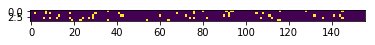

In [22]:
#Generar aleatoriamente entrada inicial

w = np.random.choice([0, 1], size=(tiempos_previos,156),  p=[0.95,0.05])
plt.imshow(w)

In [23]:
#Generar nueva cancion

tamano_cancion=200         #Numero de tiempos que tendra la cancion generada

u = np.zeros((1, tiempos_previos, 156), dtype=np.int32)
tamano_cancion=tamano_cancion+tiempos_previos
cancion_base=w
ent=np.zeros((tamano_cancion,156))
ent[0:tiempos_previos,:]=cancion_base
for i in tqdm(range (0,tamano_cancion-tiempos_previos)):			#Creacion de la cancion
    nueva_fila = model.predict(np.reshape(ent[i:i+tiempos_previos,:].ravel(),(1,tiempos_previos*156)), batch_size=1, verbose=1)
    if (np.all(np.round_(nueva_fila)==0)):
        nueva_fila[0,np.argsort(-nueva_fila)[0,:4]]=1
    ent[i+tiempos_previos] = nueva_fila
    ent=np.round_(ent)

ent=ent[tiempos_previos:tamano_cancion+tiempos_previos,:]

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  2%|█▋                                                                                | 4/200 [00:00<00:05, 33.87it/s]

1/1 [==============================] - 0s


  4%|███▎                                                                              | 8/200 [00:00<00:05, 34.40it/s]

1/1 [==============================] - 0s


  6%|████▍                                                                            | 11/200 [00:00<00:05, 32.30it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                           | 14/200 [00:00<00:05, 31.12it/s]

1/1 [==============================] - 0s


  9%|███████▎                                                                         | 18/200 [00:00<00:05, 30.58it/s]

1/1 [==============================] - 0s


 11%|████████▉                                                                        | 22/200 [00:00<00:05, 31.73it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                      | 26/200 [00:00<00:05, 32.19it/s]

1/1 [==============================] - 0s


 15%|████████████▏                                                                    | 30/200 [00:00<00:05, 32.75it/s]

1/1 [==============================] - 0s


 17%|█████████████▊                                                                   | 34/200 [00:01<00:04, 33.84it/s]

1/1 [==============================] - 0s


 19%|███████████████▍                                                                 | 38/200 [00:01<00:05, 32.29it/s]

1/1 [==============================] - 0s


 21%|█████████████████                                                                | 42/200 [00:01<00:04, 33.58it/s]

1/1 [==============================] - 0s


 23%|██████████████████▋                                                              | 46/200 [00:01<00:04, 34.45it/s]

1/1 [==============================] - 0s


 25%|████████████████████▎                                                            | 50/200 [00:01<00:04, 33.41it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▊                                                           | 54/200 [00:01<00:04, 33.81it/s]

1/1 [==============================] - 0s


 29%|███████████████████████▍                                                         | 58/200 [00:01<00:04, 32.99it/s]

1/1 [==============================] - 0s


 31%|█████████████████████████                                                        | 62/200 [00:01<00:04, 33.50it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▋                                                      | 66/200 [00:02<00:04, 32.47it/s]

1/1 [==============================] - 0s


 35%|████████████████████████████▎                                                    | 70/200 [00:02<00:04, 30.97it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▉                                                   | 74/200 [00:02<00:04, 29.86it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▌                                                 | 78/200 [00:02<00:04, 28.57it/s]

1/1 [==============================] - 0s


 40%|████████████████████████████████▊                                                | 81/200 [00:02<00:04, 28.32it/s]

1/1 [==============================] - 0s


 42%|██████████████████████████████████                                               | 84/200 [00:02<00:04, 27.84it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▏                                             | 87/200 [00:02<00:04, 27.21it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▊                                            | 91/200 [00:02<00:03, 28.18it/s]

1/1 [==============================] - 0s


 47%|██████████████████████████████████████                                           | 94/200 [00:03<00:03, 26.88it/s]

1/1 [==============================] - 0s


 48%|███████████████████████████████████████▎                                         | 97/200 [00:03<00:03, 27.44it/s]

1/1 [==============================] - 0s


 50%|████████████████████████████████████████                                        | 100/200 [00:03<00:03, 26.87it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:03<00:03, 26.07it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:03<00:03, 25.28it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:03<00:04, 21.32it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:03<00:04, 21.62it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:04<00:03, 22.16it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:04<00:03, 24.04it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:04<00:03, 25.36it/s]

1/1 [==============================] - 0s


 62%|██████████████████████████████████████████████████                              | 125/200 [00:04<00:02, 26.38it/s]

1/1 [==============================] - 0s


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:04<00:02, 27.22it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:04<00:02, 27.27it/s]

1/1 [==============================] - 0s


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:04<00:02, 27.79it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:04<00:02, 28.99it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:04<00:01, 29.83it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:05<00:01, 30.17it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:05<00:01, 30.59it/s]

1/1 [==============================] - 0s


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:05<00:01, 30.99it/s]

1/1 [==============================] - 0s


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:05<00:01, 29.71it/s]

1/1 [==============================] - 0s


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:05<00:01, 27.65it/s]

1/1 [==============================] - 0s


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:05<00:01, 26.97it/s]

1/1 [==============================] - 0s


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:05<00:01, 25.21it/s]

1/1 [==============================] - 0s


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:05<00:01, 26.37it/s]

1/1 [==============================] - 0s


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [00:06<00:01, 23.04it/s]

1/1 [==============================] - 0s


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [00:06<00:01, 22.10it/s]

1/1 [==============================] - 0s


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [00:06<00:01, 19.93it/s]

1/1 [==============================] - 0s


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [00:06<00:00, 21.28it/s]

1/1 [==============================] - 0s


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [00:06<00:00, 22.70it/s]

1/1 [==============================] - 0s


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:06<00:00, 24.80it/s]

1/1 [==============================] - 0s


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:06<00:00, 25.55it/s]

1/1 [==============================] - 0s


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:07<00:00, 25.84it/s]

1/1 [==============================] - 0s


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:07<00:00, 26.92it/s]

1/1 [==============================] - 0s


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.96it/s]


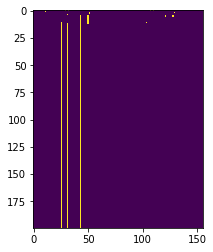

In [25]:
plt.imshow(ent)

In [21]:
#Guardar archivo midi

manipulacion_midi.noteStateMatrixToMidi(ent, "./cancion_generada5")